In [66]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.models import load_model
from keras.layers import UpSampling2D, AvgPool2D
from skimage.io import imread
from skimage.transform import resize
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.morphology import binary_opening, disk, label

In [67]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]
    
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [68]:
DATA_PATH   = '../input/airbus-ship-detection/'
TEST_PATH   = DATA_PATH+'test_v2/' 

In [69]:
model=load_model('../input/models/model_iou_coef_loss.h5', custom_objects={'iou_coef_loss': iou_coef_loss, 'iou_coef':iou_coef})

In [70]:
fullres_model = Sequential()
fullres_model.add(AvgPool2D((3,3), input_shape = (None, None, 3)))
fullres_model.add(model)
fullres_model.add(UpSampling2D((3,3)))

In [71]:
def raw_prediction(img, path=TEST_PATH):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=TEST_PATH):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

In [72]:
test_paths = np.array(os.listdir(TEST_PATH))
print(len(test_paths), 'test images found')

15606 test images found


In [76]:
def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in test_paths[0:100]: ## only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

In [77]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
print(sub.shape[0])
sub.head()

68


,ImageId,EncodedPixels
0,2bb90616e.jpg,247131 2 247898 4 248665 6 249432 7 250199 8 2...
1,ccdcf85b3.jpg,323399 1 324166 3 324930 8 325697 10 326464 12...
2,36a42f8ff.jpg,83274 8 84041 10 84808 12 85575 14 86342 16 87...
3,892380539.jpg,242634 5 243401 7 244168 9 244935 10 245702 10...
4,6720d966e.jpg,346008 5 346775 7 347542 9 348310 10 349078 11...


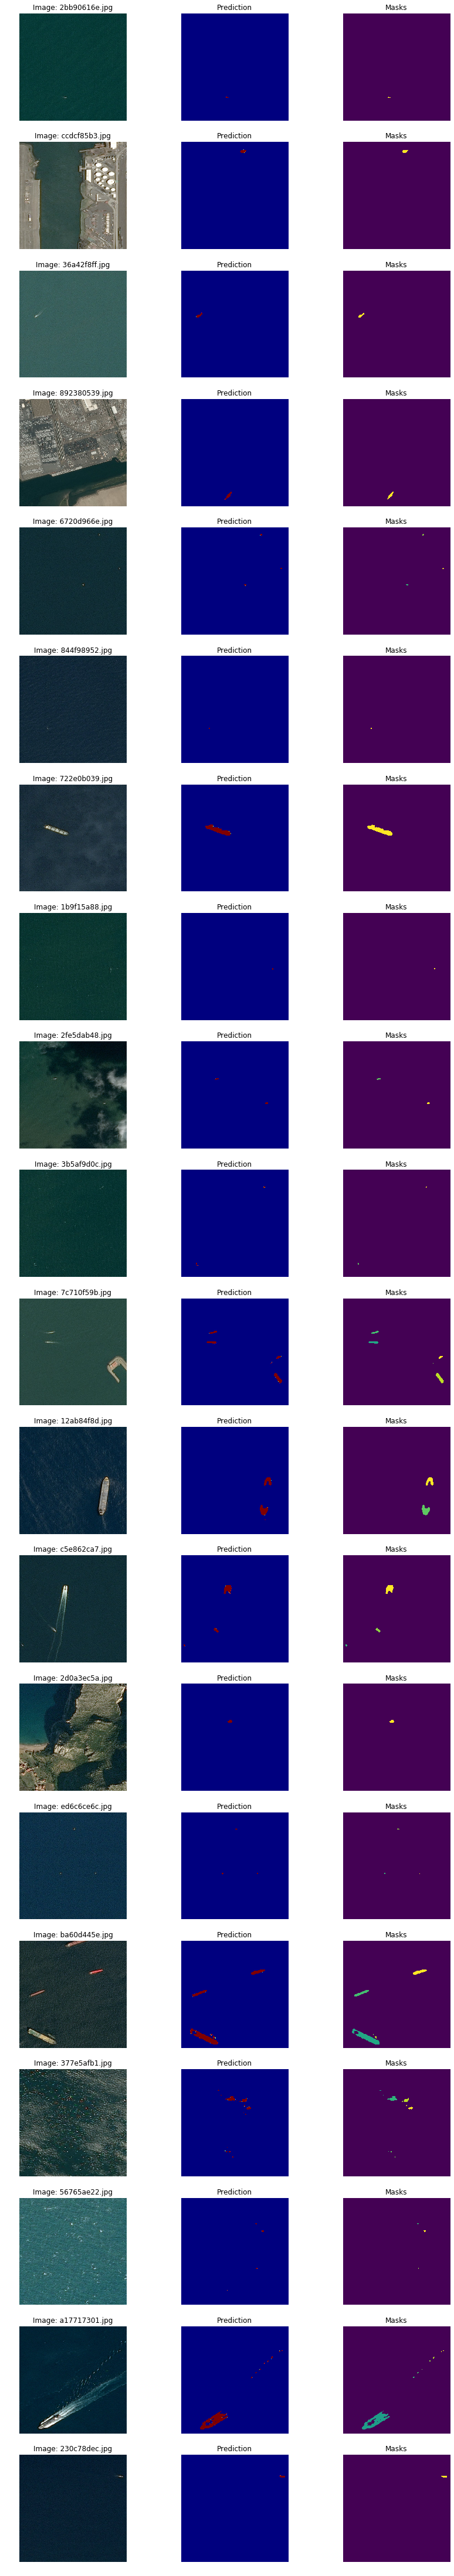

In [78]:
## let's see what we got
TOP_PREDICTIONS = 20
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 3, figsize = (14, TOP_PREDICTIONS*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    pred, c_img = raw_prediction(c_img_name)
    ax1.imshow(c_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(pred[...,0], cmap=get_cmap('jet'))
    ax2.set_title('Prediction')
    ax3.imshow(masks_as_color(sub.query('ImageId==\"{}\"'.format(c_img_name))['EncodedPixels']))
    ax3.set_title('Masks')